In [13]:

import requests
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import time


In [29]:
import math

In [1]:
!curl "https://qrng.idqloud.com/api/1.0/short?max=32767&min=-32768&quantity=10" -X GET -H "X-API-KEY: aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"


{"data":[6524,28867,-21234,12193,664,-32257,-908,-13872,3501,-7091],"dataType":"int16"}

In [2]:
def Linear_Congruential_Generator(seed, multiplier, increment, modulus, num_samples):
    x = seed
    dtype = np.uint32 if modulus <= 2**32 else np.uint64
    sequence = np.empty(num_samples, dtype=dtype)
    for i in range(num_samples):
        x = (multiplier * x + increment) % modulus
        sequence[i] = x
    return sequence

In [3]:
class JitterRNG:
    def __init__(self, pool_size=256):
        self.entropy_pool = deque(maxlen=pool_size)
        self.pool_size = pool_size
        self.last_time = None

    def _collect_timing_jitter(self, iterations=1000):
        jitter_data = []
        self.last_time = time.perf_counter_ns()
        for _ in range(iterations):
            dummy_var = 1
            for i in range(10):
                 dummy_var = (dummy_var * 1664525 + 1013904223) % (2**32)
            current_time = time.perf_counter_ns()
            time_diff = current_time - self.last_time
            lsb = time_diff & 0xFF
            jitter_data.append(lsb)
            self.last_time = current_time
        return jitter_data

    def fill_entropy_pool(self):
        jitter_data = self._collect_timing_jitter(self.pool_size)
        for value in jitter_data:
            self.entropy_pool.append(value)
        return jitter_data

    def get_random_bytes(self, num_bytes=32):
        if len(self.entropy_pool) < self.pool_size:
            self.fill_entropy_pool()
        pool_bytes = bytes(self.entropy_pool)
        mixed_entropy = hashlib.sha256(pool_bytes).digest()
        result = bytearray()
        while len(result) < num_bytes:
            self.fill_entropy_pool()
            pool_bytes = bytes(self.entropy_pool)
            h = hashlib.sha256()
            h.update(mixed_entropy)
            h.update(pool_bytes)
            mixed_entropy = h.digest()
            result.extend(mixed_entropy)
        return bytes(result[:num_bytes])

    def get_random_int(self, min_val=0, max_val=100):
        range_size = max_val - min_val + 1
        if range_size <= 0:
            raise ValueError("Invalid range")
        bits_needed = (range_size - 1).bit_length()
        if bits_needed == 0:
             bits_needed = 1
        bytes_needed = (bits_needed + 7) // 8
        random_bytes = self.get_random_bytes(bytes_needed)
        value = int.from_bytes(random_bytes, byteorder='big')
        return min_val + (value % range_size)

    def analyze_randomness(self, sample_size=1000):
         print("Analysis method not implemented for direct comparison in this task.")
         pass

In [5]:
def compute_entropy(X, num_bins=256, entropy_type='shannon'):
    if len(X) == 0:
        return 0
    hist, _ = np.histogram(X, bins=num_bins, density=False)

    total_counts = np.sum(hist)
    if total_counts == 0:
        return 0

    probabilities = hist / total_counts

    if entropy_type == 'shannon':
        entropy = 0
        non_zero_probabilities = probabilities[probabilities > 0]
        if len(non_zero_probabilities) > 0:
             entropy = -np.sum(non_zero_probabilities * np.log2(non_zero_probabilities))
        return entropy
    elif entropy_type == 'min':
        max_prob = np.max(probabilities)
        if max_prob > 0:
            return -math.log2(max_prob)
        else:
            return 0
    else:
        print(f"Warning: Unknown entropy type '{entropy_type}'. Returning 0.")
        return 0

In [6]:
QRNG_API_KEY = "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"
QRNG_API_URL = "https://qrng.idqloud.com/api/1.0/"

In [8]:
def get_qrng_data(data_type="short", quantity=10, min_val=None, max_val=None):
    endpoint = f"{QRNG_API_URL}{data_type}"
    params = {
        "quantity": quantity
    }
    if data_type in ["short", "int", "long"]: 
        if min_val is not None:
            params["min"] = min_val
        if max_val is not None:
            params["max"] = max_val

    headers = {
        "X-API-KEY": QRNG_API_KEY
    }

    print(f"Requesting {quantity} random values of type '{data_type}' from QRNG API...")
    try:
        response = requests.get(endpoint, headers=headers, params=params)
        response.raise_for_status() 

        data = response.json()

        if data.get("success"):
            return data.get("data")
        else:
            print(f"API request failed: {data.get('message', 'Unknown error')}")
            return None

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from QRNG API: {e}")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON response from QRNG API.")
        return None

In [11]:
# Example usage of the QRNG API function:
# Get 10 int16 random numbers between -32768 and 32767
qrng_short_example = get_qrng_data(data_type="short", quantity=10, min_val=-32768, max_val=32767)
if qrng_short_example:
    print("\nExample QRNG 'short' data:", qrng_short_example)

qrng_bytes_example = get_qrng_data(data_type="bytes", quantity=20)
if qrng_bytes_example:
     print("\nExample QRNG 'bytes' data (as integers):", qrng_bytes_example)
     qrng_bytes_obj = bytes(qrng_bytes_example)
     print("Example QRNG 'bytes' data (as bytes):", qrng_bytes_obj.hex())

Requesting 10 random values of type 'short' from QRNG API...
API request failed: Unknown error
Requesting 20 random values of type 'bytes' from QRNG API...
Error fetching data from QRNG API: 403 Client Error: Forbidden for url: https://qrng.idqloud.com/api/1.0/bytes?quantity=20


In [12]:
def get_bitrate(generator_func, num_samples, sample_unit='bytes', sample_size_bits=8):
    start_time = time.perf_counter()
    samples = generator_func(num_samples) 
    end_time = time.perf_counter()

    if samples is None:
        print("Generator function returned None.")
        return None

    duration = end_time - start_time

    if duration <= 0:
        print("Warning: Duration is zero or negative. Cannot calculate bitrate.")
        return None

    total_bits = 0
    if sample_unit == 'bytes':
        if isinstance(samples, (list, np.ndarray)):
             total_bits = len(samples) * 8
        elif isinstance(samples, bytes):
             total_bits = len(samples) * 8
        else:
             print(f"Unsupported sample unit '{sample_unit}' for type {type(samples)}")
             return None
    elif sample_unit == 'values':
         total_bits = len(samples) * sample_size_bits
    else:
        print(f"Unsupported sample unit: {sample_unit}")
        return None

    bitrate = total_bits / duration
    return bitrate



In [26]:
def plot_entropy_comparison(generators, sample_size=10000, num_bins=256):
    entropy_values = {}

    print(f"Calculating entropy for {sample_size} samples from each generator...")

    for name, (generator_func, sample_unit, sample_size_bits) in generators.items():
        print(f"  Generating samples for {name}...")
        samples = None
        if name == "QRNG (Bytes)":
             samples = generator_func(sample_size)
             if samples:
                  samples = np.array(samples) / 255.0 
        elif name == "QRNG (Short)":
             samples = generator_func(data_type="short", quantity=sample_size, min_val=-32768, max_val=32767)
             if samples:
                 samples = (np.array(samples) - (-32768)) / (32767 - (-32768))
        elif name == "LCG":
             lcg_modulus = 2**32 
             samples = generator_func(seed=123, multiplier=1664525, increment=1013904223, modulus=lcg_modulus, num_samples=sample_size)
             samples = samples / lcg_modulus
        elif name == "JitterRNG":
             jitter_rng_instance = JitterRNG(pool_size=256) 
             samples = [jitter_rng_instance.get_random_int(0, 255) for _ in range(sample_size)]
             samples = np.array(samples) / 255.0 

        if samples is not None and len(samples) > 0:
            shannon_entropy = compute_entropy(samples, num_bins=num_bins, entropy_type='shannon')
            entropy_values[name] = shannon_entropy
            print(f"    {name} Shannon Entropy: {shannon_entropy:.4f} bits")
        else:
            print(f"    Could not generate samples for {name}.")
            entropy_values[name] = None

    if entropy_values:
        valid_generators = {k: v for k, v in entropy_values.items() if v is not None}
        if valid_generators:
            names = list(valid_generators.keys())
            entropies = list(valid_generators.values())

            plt.figure(figsize=(10, 6))
            plt.bar(names, entropies, color=['blue', 'green', 'red', 'purple'])
            plt.ylabel('Shannon Entropy (bits)')
            plt.title(f'Shannon Entropy Comparison ({sample_size} samples, {num_bins} bins)')
            plt.ylim(0, math.log2(num_bins) + 1) 
            plt.grid(axis='y', alpha=0.7)
            plt.show()
        else:
            print("No valid entropy values to plot.")
    else:
        print("No entropy data available for plotting.")



In [17]:
comparison_sample_size_bytes = 10000 
comparison_sample_size_entropy = 10000 
entropy_bins_for_comparison = 256 

print("\n--- Performance Comparison (Bitrate and Entropy) ---")

print(f"\nMeasuring bitrate using {comparison_sample_size_bytes} bytes/equivalent...")

bitrates = {}

def qrng_bytes_generator(num_bytes):
    return get_qrng_data(data_type="bytes", quantity=num_bytes)

qrng_bytes_bitrate = get_bitrate(qrng_bytes_generator, comparison_sample_size_bytes, sample_unit='bytes')
if qrng_bytes_bitrate is not None:
    bitrates["QRNG (Bytes)"] = qrng_bytes_bitrate
    print(f"QRNG (Bytes) Bitrate: {qrng_bytes_bitrate / 1000:.2f} Kbps")

lcg_modulus = 2**32
lcg_bits_per_sample = lcg_modulus.bit_length() 

num_lcg_samples_for_bitrate = int((comparison_sample_size_bytes * 8) / lcg_bits_per_sample)
if num_lcg_samples_for_bitrate > 0:
    def lcg_bitrate_generator(num_samples):
         return Linear_Congruential_Generator(seed=123, multiplier=1664525, increment=1013904223, modulus=lcg_modulus, num_samples=num_samples)

    lcg_bitrate = get_bitrate(lcg_bitrate_generator, num_lcg_samples_for_bitrate, sample_unit='values', sample_size_bits=lcg_bits_per_sample)
    if lcg_bitrate is not None:
        bitrates["LCG"] = lcg_bitrate
        print(f"LCG Bitrate: {lcg_bitrate / 1000:.2f} Kbps")
else:
    print("Not enough bits requested for LCG bitrate calculation.")


--- Performance Comparison (Bitrate and Entropy) ---

Measuring bitrate using 10000 bytes/equivalent...
Requesting 10000 random values of type 'bytes' from QRNG API...
Error fetching data from QRNG API: 403 Client Error: Forbidden for url: https://qrng.idqloud.com/api/1.0/bytes?quantity=10000
Generator function returned None.
LCG Bitrate: 108740.18 Kbps


JitterRNG Bitrate: 1084.47 Kbps


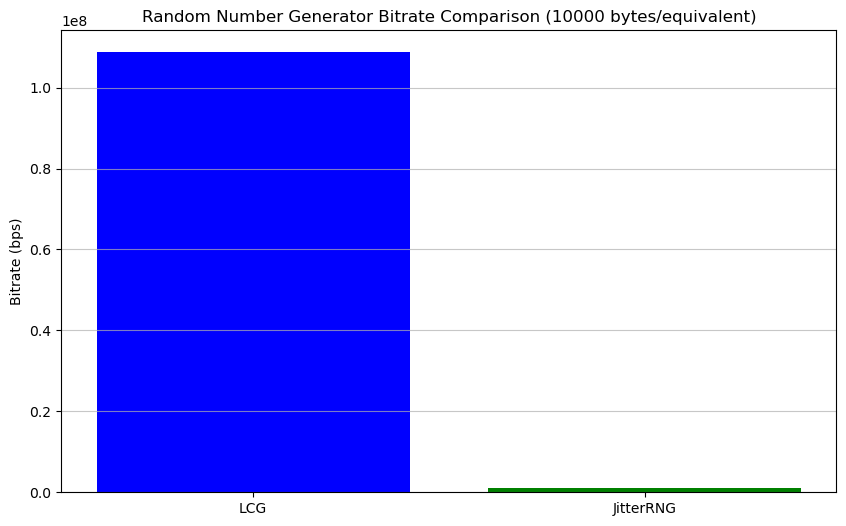

In [23]:
def jitter_rng_bytes_generator(num_bytes):
     jitter_rng_instance = JitterRNG(pool_size=256) 
     return jitter_rng_instance.get_random_bytes(num_bytes)

jitter_rng_bitrate = get_bitrate(jitter_rng_bytes_generator, comparison_sample_size_bytes, sample_unit='bytes')
if jitter_rng_bitrate is not None:
    bitrates["JitterRNG"] = jitter_rng_bitrate
    print(f"JitterRNG Bitrate: {jitter_rng_bitrate / 1000:.2f} Kbps")


if bitrates:
    names = list(bitrates.keys())
    rates = list(bitrates.values())

    plt.figure(figsize=(10, 6))
    plt.bar(names, rates, color=['blue', 'green', 'red'])
    plt.ylabel('Bitrate (bps)')
    plt.title(f'Random Number Generator Bitrate Comparison ({comparison_sample_size_bytes} bytes/equivalent)')
    plt.grid(axis='y', alpha=0.7)
    plt.show()
else:
    print("No bitrate data available for plotting.")



Measuring entropy using 10000 samples...
Calculating entropy for 10000 samples from each generator...
  Generating samples for QRNG (Bytes)...
Requesting 10000 random values of type 'bytes' from QRNG API...
Error fetching data from QRNG API: 403 Client Error: Forbidden for url: https://qrng.idqloud.com/api/1.0/bytes?quantity=10000
    Could not generate samples for QRNG (Bytes).
  Generating samples for LCG...
    LCG Shannon Entropy: 7.9839 bits
  Generating samples for JitterRNG...
    JitterRNG Shannon Entropy: 7.9829 bits


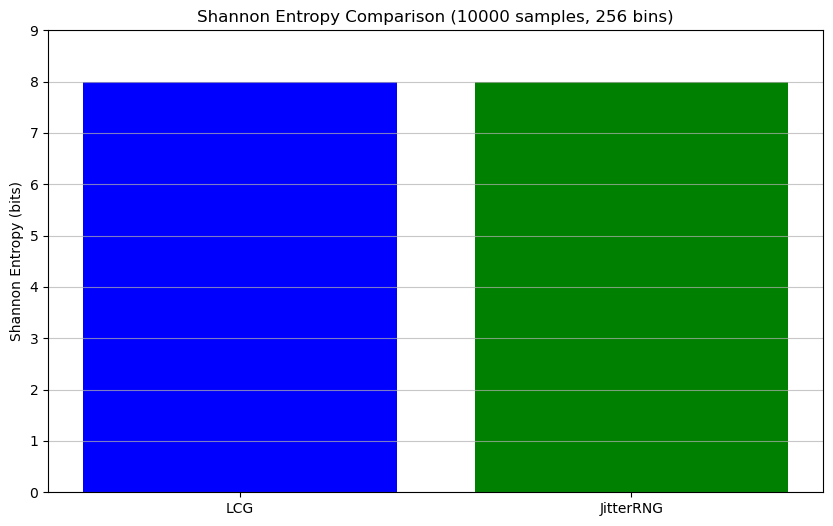

In [30]:
print(f"\nMeasuring entropy using {comparison_sample_size_entropy} samples...")

entropy_generators = {
    "QRNG (Bytes)": (qrng_bytes_generator, 'bytes', 8), 
    "LCG": (Linear_Congruential_Generator, 'values', lcg_bits_per_sample), 
    "JitterRNG": (JitterRNG, 'bytes', 8) 
}

plot_entropy_comparison(entropy_generators, sample_size=comparison_sample_size_entropy, num_bins=entropy_bins_for_comparison)


In [22]:
import hashlib

In [ ]:
"""
You can paste the other environmental entropy based TRNGs from Task 2 and compare the performance
Compare your written QRNG to the previous TRNGs. Be sure to compare them with respect to bitrate and entropy.
"""
def plot_entropy():
    pass # TODO

def get_bitrate():
    pass # TODO